In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from IPython.display import display, HTML


In [6]:
# data import
x = pd.read_csv("train.csv")
y = x.pop("Survived")


In [7]:
# scan ordinal data
x.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
# age has missing values... I'm going to impute the mean to each missing data point
x["Age"].fillna(x.Age.mean(), inplace=True)

# make sure it worked...
x.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


I'm going to start by making a quick and dirty model that only uses numerical data. 

In [9]:
numerical_data=list(x.dtypes[x.dtypes != "object"].index)
x[numerical_data].head(5)

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


In [10]:
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
model.fit(x[numerical_data], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [11]:
# training set out of bag R^2
print(model.oob_score_)
y_oob = model.oob_prediction_

0.1361695005913669


In [12]:
# test set
print(roc_auc_score(y, y_oob))

0.7399551550399983


numerical bench mark made... the current model isn't amazing but I can include categorical features later.

A value below 0.5 indicates a very poor model.
A value of 0.5 means that the model is no better than predicting an outcome than random chance.
Values over 0.7 indicate a good model.
Values over 0.8 indicate a strong model.
A value of 1 means that the model perfectly predicts those group members who will experience a certain outcome and those who will not.



y_oob "Y Out of Bag" is an array of survival probability where each human represents a unique indice

In [13]:
def describe_categorical_data(x):
    display(HTML(x[x.columns[x.dtypes == 'object']].describe().to_html()))

In [14]:
# running this code more than once will cause an error because column deletion is final...
x = x.drop(["PassengerId", "Name", "Ticket"], axis=1)

In [15]:
describe_categorical_data(x)

,Sex,Cabin,Embarked
count,891,204,889
unique,2,147,3
top,male,B96 B98,S
freq,577,4,644


In [16]:
# slick function that cleans "cabin" by returning "None" for missing data and the first character for present data
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return "None"
x["Cabin"] = x.Cabin.apply(clean_cabin)

In [17]:
#Cleaning categorical variables and creation of dummy arrays
categorical_variables = ['Sex', 'Cabin', 'Embarked']

for i in categorical_variables:
    #Filling missing cattergorical data
    x[i].fillna("Missing", inplace=True)
    # creating an array of dummies
    dummies = pd.get_dummies(x[i], prefix=i)
    # updating df to be dummy coded
    x = pd.concat([x, dummies], axis=1)
    x.drop([i], axis=1, inplace=True)

In [18]:
# dummy variables worked...
x

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
887,1,19.000000,0,0,30.0000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
888,3,29.699118,1,2,23.4500,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
889,1,26.000000,0,0,30.0000,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [19]:
# wanted to give this print method a try because I've seen it a few times on YouTube
def printall(x, max_rows=5):
    from IPython.display import display, HTML
    display(HTML(x.to_html(max_rows=max_rows)))
print(x)

     Pclass        Age  SibSp  Parch     Fare  Sex_female  Sex_male  Cabin_A  \
0         3  22.000000      1      0   7.2500           0         1        0   
1         1  38.000000      1      0  71.2833           1         0        0   
2         3  26.000000      0      0   7.9250           1         0        0   
3         1  35.000000      1      0  53.1000           1         0        0   
4         3  35.000000      0      0   8.0500           0         1        0   
..      ...        ...    ...    ...      ...         ...       ...      ...   
886       2  27.000000      0      0  13.0000           0         1        0   
887       1  19.000000      0      0  30.0000           1         0        0   
888       3  29.699118      1      2  23.4500           1         0        0   
889       1  26.000000      0      0  30.0000           0         1        0   
890       3  32.000000      0      0   7.7500           0         1        0   

     Cabin_B  Cabin_C  Cabin_D  Cabin_E

In [20]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(x, y)
print(roc_auc_score(y, model.oob_prediction_))

0.8635211282608464


## Exploritory Data Analysis

In [21]:
# Which features are most important in the model?
model.feature_importances_

array([9.11384671e-02, 2.38891052e-01, 4.43567267e-02, 2.15831071e-02,
       2.15047796e-01, 1.43423437e-01, 1.58822440e-01, 2.95342368e-03,
       3.79055011e-03, 6.47116172e-03, 4.30998991e-03, 8.59480266e-03,
       1.02403226e-03, 8.12054428e-04, 2.67741854e-02, 6.64265010e-05,
       1.06189189e-02, 0.00000000e+00, 6.00379221e-03, 1.53176370e-02])

Scientific notation sucks... and I'd like to tag each importance score with the feature name for ease of interpretation

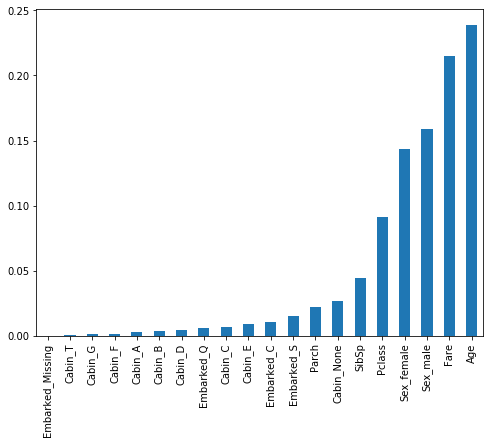

In [22]:
# At some point I need to figure out how to sort these descending...
feature_importances = pd.Series(model.feature_importances_, index=x.columns)
feature_importances = feature_importances.sort_values()
feature_importances.plot(kind="bar", figsize=(8,6));

## Still Working on this slick function

I want to make aggregate bars for Cabin, Sex, Embarked etc... I burrowed this method from a Kaggle submission... I couldn't have done this using pure Python... #HatTip


In [23]:
def aggregate_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    if autoscale:
        x_scale = model.feature_importances_.max() + headroom
    else:
        x_scale = 1
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns:
        for col_name in summarized_columns:
            # sum all the features that contain col_name, store in a temporary sum value
            sum_value = sum(x for i in feature_dict.keys() if col_name in i)
            
            # removing dictionary keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            for i in keys_to_remove:
                feature_dict.pop(i)
            # read the summed field
            feature_dict[col_name] = sum_value
            
    results = pd.Series(feature_dict.values(), index=feature_dict.keys())
    results = results.sort_values(axis=1)
    results.plot(kind="bar", figsize=(width,len(results)/4), xlim=(0,x_scale))
            
    
aggregate_feature_importances(model, x.columns, summarized_columns=categorical_variables)

ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>

## Optimization of Parameters
    #Parameters that should be optomized
    - n_estimators: The number of trees in the forest. Use as many as my computer/VM can handle
    - max_features: The nnumber of features to consider when looking for the best split. Try ( "auto","None","sqrt", "log2", "0.9" and "0.2"
    - min_samples_leaf: The minimum number of samples in newly created leafs. Try [1,2,3] if 3 provides the best ROC then try 1-10.
    #Computer/Memory related parameters
    - n_jobs: Determinds if multiple processors should be used to train and test the model. Set to -1 but also try 1 and time how long it takes for the model to run using %%timeit

# n_jobs

In [24]:
%%timeit
model = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)

5.7 µs ± 32.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [25]:
%%timeit
model = RandomForestRegressor(n_estimators=100, oob_score=True, n_jobs=1, random_state=42)

5.72 µs ± 20.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# n_estimators

30 trees
0.8538704076524037

50 trees
0.8606983457429244

100 trees
0.8635211282608464

200 trees
0.8621629970493935

500 trees
0.863739494455629

1000 trees
0.864053728735926

2000 trees
0.8634439011919599



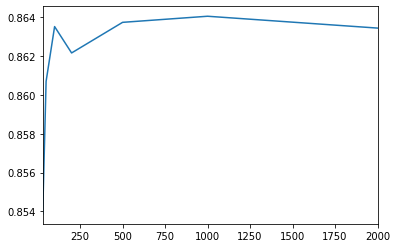

In [36]:
results = []
n_estimators = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimators:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(x, y)
    print (trees, "trees")
    roc = roc_auc_score(y, model.oob_prediction_)
    print (roc)
    results.append(roc)
    print ("")
    
pd.Series(results, n_estimators).plot();

n_estimators = 1000 is optimal

For regression it's best to use all variables at each split which is "Auto"
For classification tasks... use the sqare root of how many variables/features you have.

auto option
0.864053728735926

None option
0.864053728735926

sqrt option
0.8634066191587043

log2 option
0.8634066191587043

0.9 option
0.863545095282225

0.2 option
0.8634066191587043



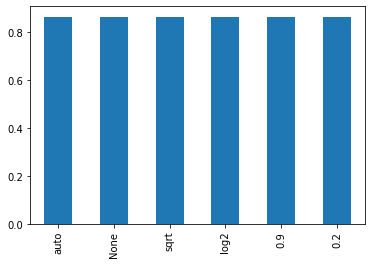

In [43]:
results_2 = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(x, y)
    print(max_features, "option")
    roc = roc_auc_score(y, model.oob_prediction_)
    print (roc)
    results_2.append(roc)
    print ("")
#This isn't plotting in the scaling method I prefer. Not sure why... trouble shoot later...    
pd.Series(results_2, max_features_options).plot(kind="bar", xlim=(.85, .95));

1 min samples
0.864053728735926

2 min samples
0.8696433707218867

3 min samples
0.8715713844416749

4 min samples
0.87347809414246

5 min samples
0.8742636798432022

6 min samples
0.8740293356341673

7 min samples
0.8732890209738068

8 min samples
0.8718616517005933

9 min samples
0.8692785393964572

10 min samples
0.86742508974318



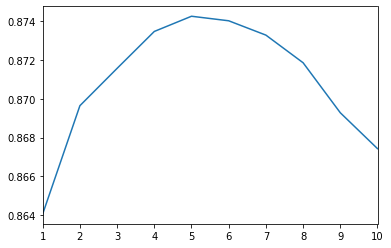

In [48]:
results_3 = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=samples)
    model.fit(x, y)
    
    print(samples, "min samples")
    roc = roc_auc_score(y, model.oob_prediction_)
    print(roc)
    results_3.append(roc)
    print ("")

pd.Series(results_3, min_samples_leaf_options).plot()
    

# Final Optimized Model
## The best model I can make without engineering any new featues


In [52]:
model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features="auto", min_samples_leaf=5)
model.fit(x, y)
roc = roc_auc_score(y, model.oob_prediction_)
print("My final C-stat/ROC-AUC =", roc)
    

My final C-stat/ROC-AUC = 0.8742636798432022
